In [1]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
import os
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import RF_regressor, plot_importances, encode_tulabel
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.utils.directories import get_parent_directory

In [2]:
parent_dir = get_parent_directory()
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/1906_time.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

## Final model


with MLD

In [5]:
# Features:
# xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['sea_ice_concentration','latitude','depth','hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist = ['log_eps']
pipeline, y_test, X_test, importances, X_train, y_train = RF_regressor(arctic_df, xstringlist_all, ystringlist)

In [6]:
# Predict the test set labels
y_pred = pipeline.predict(X_test)
r2_score(y_test, y_pred)

0.986943668202188

In [ ]:
fig = plt.figure(figsize=[22, 10])
ax_imp = fig.add_subplot(1, 1, 1)

plot_importances(xstringlist_all, importances, ax=ax_imp)
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
def generate_learning_curve(pipeline, X, y):
    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    return train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = generate_learning_curve(pipeline, X_train, y_train)

plt.figure()
plt.title('Learning Curve')
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

plt.legend(loc="best")
plt.show()

exl MLD

In [11]:
# Features:
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]
# xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['sea_ice_concentration','latitude','depth','hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist = ['log_eps']
pipelineMLD, y_testMLD, X_testMLD, importancesMLD, X_trainMLD, y_trainMLD = RF_regressor(MLD_df, xstringlist_all, ystringlist)

In [12]:
# Predict the test set labels
y_predMLD = pipelineMLD.predict(X_testMLD)
r2_score(y_testMLD, y_predMLD)

0.9885674368912154

In [13]:
from sklearn.model_selection import learning_curve
def generate_learning_curve(pipeline, X, y):
    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    return train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = generate_learning_curve(pipelineMLD, X_trainMLD, y_trainMLD)

plt.figure()
plt.title('Learning Curve')
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

plt.legend(loc="best")
plt.show()

KeyboardInterrupt: 

In [ ]:
import joblib

In [ ]:
# Save the parameters
joblib.dump(pipelineMLD, 'RandomForest/best_model.sav')
# joblib.dump(r2_tune, 'XGboost/r2_tune.sav')
joblib.dump(y_testMLD, 'RandomForest/y_test_MLDsav')
joblib.dump(y_predMLD, 'RandomForest/y_pred_MLD.sav')
joblib.dump(X_testMLD, 'RandomForest/X_test_MLD.sav')
# joblib.dump(feature_importances_tune, 'XGboost/feature_importances_tune.sav')

In [14]:
y_test = pd.DataFrame(y_test, columns=["log_eps"])

In [16]:
y_pred = pd.DataFrame(y_pred, columns=["log_eps"])

Text(0.5, 1.0, 'Predictions from RandomForestClassifier')

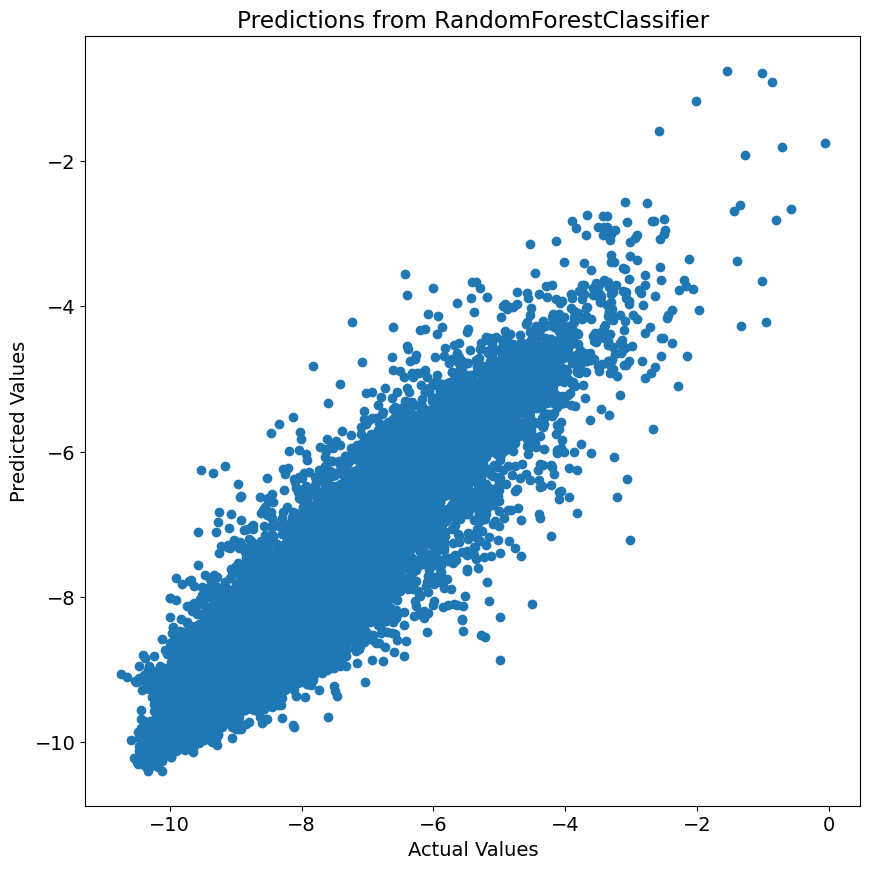

In [22]:
plt.scatter(y_test, y_pred)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions from RandomForestClassifier')

Text(0.5, 1.0, 'Density Plot of Residuals')

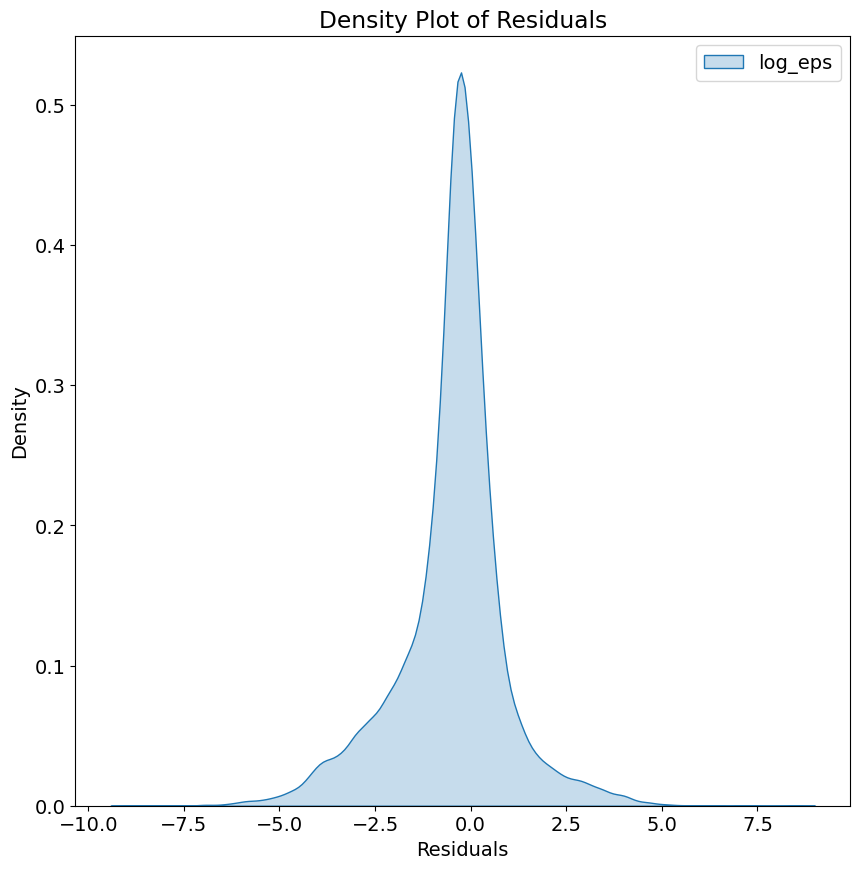

In [25]:
import seaborn as sns

residuals = y_pred - y_test
sns.kdeplot(data=residuals, shade=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Density Plot of Residuals')

## Vary train test split

In [4]:
# Features:
# xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['sea_ice_concentration','latitude','depth','hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist = ['log_eps']

pipeline, y_test, X_test, importances, X_train, y_train = RF_regressor(arctic_df, xstringlist_all, ystringlist, "Haakon Mosby")

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error
# Predict the test set labels
y_pred= pipeline.predict(X_test)
r2_score(y_test.values.flatten(), y_pred)

# Calculate the R2 score
r2 = r2_score(y_test.values.flatten(), y_pred)

# Calculate the mean error (ME)
me = np.mean(y_pred - y_test.values.flatten())

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.flatten(), y_pred)

# Calculate the residuals
residuals = y_test.values.flatten() - y_pred

# Calculate the standard deviation of the residuals
residual_std = np.std(residuals)

# Print the metrics
print("R2 Score: {:.4f}".format(r2))
print("Mean Error (ME): {:.4f}".format(me))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))
print("Residual Standard Deviation: {:.4f}".format(residual_std))

R2 Score: -37.8540
Mean Error (ME): 12.3714
Mean Absolute Error (MAE): 12.3714
Residual Standard Deviation: 1.8057


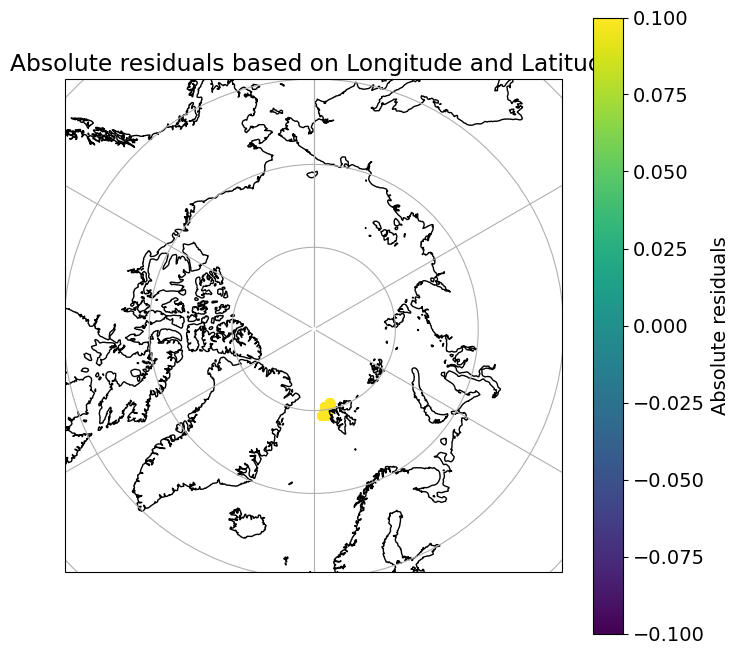

In [7]:
arctic_df = encode_tulabel(arctic_df)
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test, columns=xstringlist_all)
y_test_df_SIC = pd.DataFrame(y_test, columns=ystringlist)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)

merged_df_SIC = SIC_all_testdf.merge(arctic_df, on=xstringlist_all+ystringlist)
merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all+ystringlist)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])
stereo_plot(merged_df_SIC, abs(residuals_SIC), "Absolute residuals")